Problem statement: Predict next-day closing prices using LSTM.

Data: Fetched using yfinance for multiple stocks (AAPL, GOOG, RELIANCE.NS, etc.)

Approach: Add technical indicators, normalize, sequence, train LSTM.

In [31]:

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from datetime import datetime
import random
import numpy as np
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)



In [32]:

def normalize_data(df):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    return scaled_data, scaler

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i, 3])  # Close price
    return np.array(X), np.array(y)


In [33]:

def build_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


In [34]:

stocks = ['AAPL', 'GOOG', 'IBM', 'RELIANCE.NS', 'INFY.NS', 'HDFCBANK.NS']
all_X, all_y = [], []

for ticker in stocks:
    df = fetch_data(ticker)
    df = add_moving_average(df)
    df = add_rsi(df)
    df = add_macd(df)
    df.dropna(inplace=True)

    features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MA', 'RSI', 'MACD', 'Signal_Line']]
    scaled, _ = normalize_data(features)
    X, y = create_sequences(scaled)

    all_X.append(X)
    all_y.append(y)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [35]:
X_all = np.concatenate(all_X, axis=0)
y_all = np.concatenate(all_y, axis=0)

split = int(0.8 * len(X_all))
X_train, X_val = X_all[:split], X_all[split:]
y_train, y_val = y_all[:split], y_all[split:]

model = build_model((X_train.shape[1], X_train.shape[2]))
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=25, batch_size=32)


C:\Users\anand\PycharmProjects\PythonProject3\.venv2\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 0.0108 - val_loss: 5.7294e-04
Epoch 2/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0019 - val_loss: 5.5328e-04
Epoch 3/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 0.0016 - val_loss: 4.6531e-04
Epoch 4/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.0013 - val_loss: 7.1619e-04
Epoch 5/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 0.0012 - val_loss: 5.0871e-04
Epoch 6/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step - loss: 0.0011 - val_loss: 6.5892e-04
Epoch 7/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 32ms/step - loss: 0.0011 - val_loss: 4.1641e-04
Epoch 8/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 9.1255e-04 - val_loss: 4.4449e-04
Epoch 9/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 9.4417e-04 - val_loss: 2.9935e-04
Epoch 10/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 8.4462e-04 - val_loss: 0.0011
Epoch 11/25
384/384 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 8.4184e-

96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


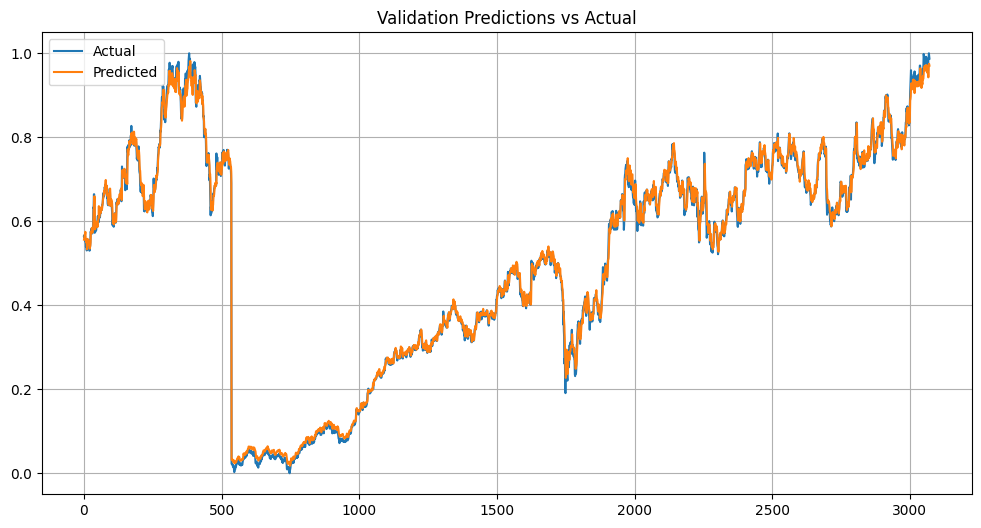

MSE: 0.0002201062147534288


In [36]:
preds = model.predict(X_val)

plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual')
plt.plot(preds, label='Predicted')
plt.title("Validation Predictions vs Actual")
plt.legend()
plt.grid(True)
plt.show()

print("MSE:", mean_squared_error(y_val, preds))


In [37]:
# Predict next-day price for a chosen stock
df = fetch_data("AAPL")
df = add_moving_average(df)
df = add_rsi(df)
df = add_macd(df)
df.dropna(inplace=True)

features = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MA', 'RSI', 'MACD', 'Signal_Line']]
scaled, scaler = normalize_data(features)
X, _ = create_sequences(scaled)

latest_seq = np.expand_dims(X[-1], axis=0)
pred = model.predict(latest_seq)

def denormalize_prediction(pred, scaler, target_index=3, n_features=9):
    padded = np.zeros((1, n_features))
    padded[0][target_index] = pred
    inv = scaler.inverse_transform(padded)
    return inv[0][target_index]

predicted_price = denormalize_prediction(pred[0][0], scaler)
print(f"Predicted Next Close Price: ${predicted_price:.2f}")


[*********************100%***********************]  1 of 1 completed


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Predicted Next Close Price: $213.46
